/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['Unnamed: 0']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['Unnamed: 0']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1415: RuntimeWarning: Number of classes in training fold (2) does not match total number of classes (3). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings

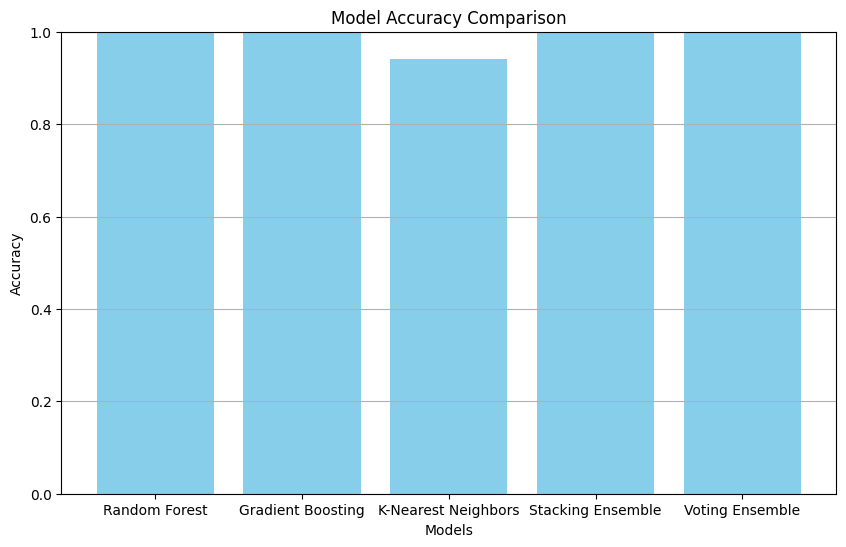

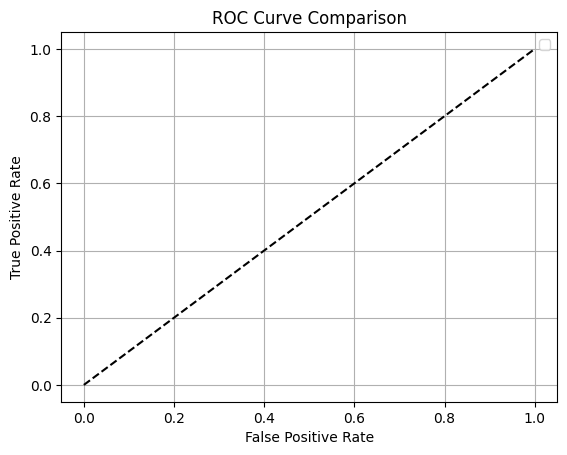

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        56
           2       1.00      1.00      1.00       149

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



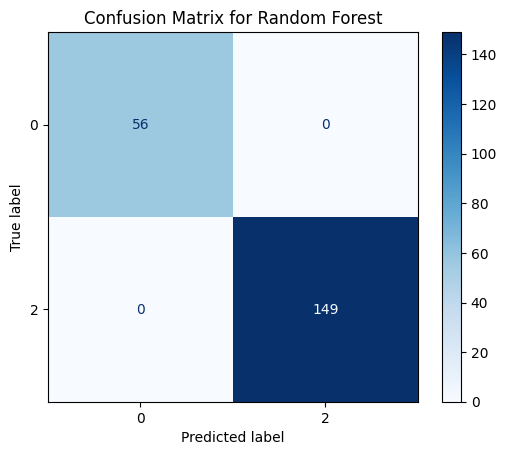

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        56
           2       1.00      1.00      1.00       149

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



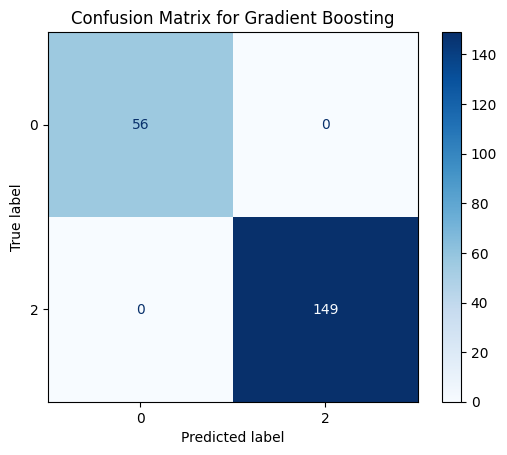

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        56
           2       0.95      0.97      0.96       149

    accuracy                           0.94       205
   macro avg       0.94      0.92      0.92       205
weighted avg       0.94      0.94      0.94       205



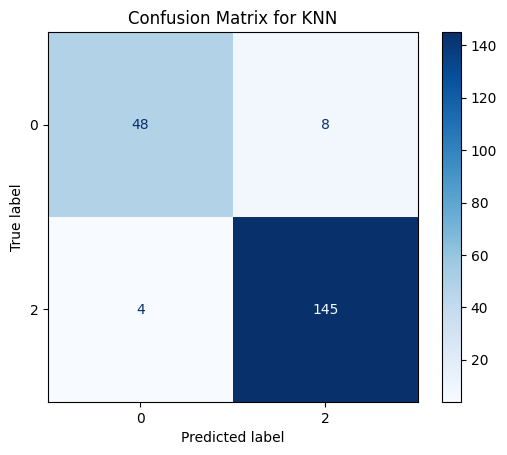

Stacking Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        56
           2       1.00      1.00      1.00       149

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



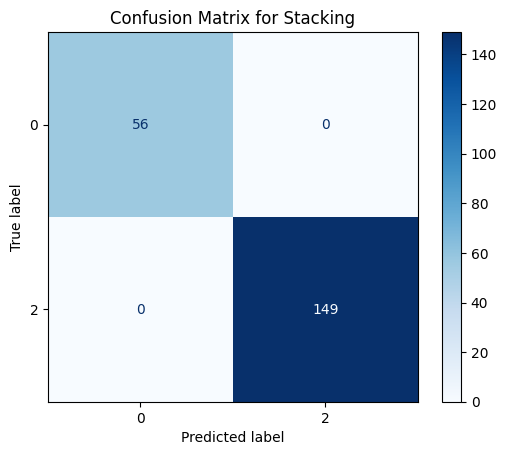

Voting Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        56
           2       1.00      1.00      1.00       149

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



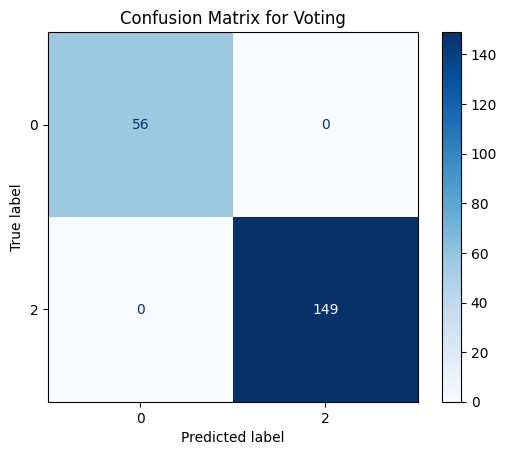

In [ ]:
# ENSEMBLE STACKING VS VOTING CLASSIFIER
# 01
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder
from sklearn.impute import SimpleImputer # Import SimpleImputer

# 02 # Load the data

data = pd.read_excel("/content/COLOR COMBINATION DATASET_FEATURE SELECTION OUTCOMES.xlsx") # Replace with the actual file path
X = data.drop('Combination', axis=1) # Features
y = data['BACKGROUND'] # Target variable

# Convert string labels to numerical using Label Encoding
le = LabelEncoder() # Create a LabelEncoder object
y = le.fit_transform(y) # Fit and transform the target variable

# Convert string features to numerical using Label Encoding
for column in X.columns:
    if X[column].dtype == 'object':  # Check if the column has string values
        X[column] = le.fit_transform(X[column])

# 03 # Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean') # Use mean imputation, you can change the strategy
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# 04 # Initialize base models
rf = RandomForestClassifier(random_state=42)
gbm = GradientBoostingClassifier(random_state=42)
knn = KNeighborsClassifier()

# 05 # Train each model
rf.fit(X_train, y_train)
gbm.fit(X_train, y_train)
knn.fit(X_train, y_train)

# 06 # Get predictions for the test set
rf_pred = rf.predict(X_test)
gbm_pred = gbm.predict(X_test)
knn_pred = knn.predict(X_test)

# 07 # Stacking Classifier
stacking_model = StackingClassifier(
 estimators=[
 ('rf', rf),
 ('gbm', gbm),
 ('knn', knn)
 ],
 final_estimator=LogisticRegression()
)
stacking_model.fit(X_train, y_train)
y_pred_stacking = stacking_model.predict(X_test)

# 07 # Voting Classifier
voting_model = VotingClassifier(estimators=[
 ('rf', rf),
 ('gbm', gbm),
 ('knn', knn)
], voting='soft')
voting_model.fit(X_train, y_train)
y_pred_voting = voting_model.predict(X_test)

# 08 # Calculate accuracy
accuracies = {
 'Random Forest': accuracy_score(y_test, rf_pred),
 'Gradient Boosting': accuracy_score(y_test, gbm_pred),
 'K-Nearest Neighbors': accuracy_score(y_test, knn_pred),
 'Stacking Ensemble': accuracy_score(y_test, y_pred_stacking),
 'Voting Ensemble': accuracy_score(y_test, y_pred_voting)
}


# 08 # Plotting Accuracy Comparison
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

# 09 # Optional: ROC Curve (for binary classification)
if len(np.unique(y)) == 2: # Check if binary classification
 plt.figure(figsize=(10, 6))

 for model, preds in zip(['Random Forest', 'Gradient Boosting', 'KNN', 'Stacking', 'Voting'],
 [rf.predict_proba(X_test)[:, 1],
 gbm.predict_proba(X_test)[:, 1],
 knn.predict_proba(X_test)[:, 1],
 stacking_model.predict_proba(X_test)[:, 1],
 voting_model.predict_proba(X_test)[:, 1]]):

   fpr, tpr, _ = roc_curve(y_test, preds)
   roc_auc = auc(fpr, tpr)
   plt.plot(fpr, tpr, label=f'{model} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

# 10
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# Print classification report for each model
for model_name, y_pred in zip(['Random Forest', 'Gradient Boosting', 'KNN', 'Stacking', 'Voting'],
 [rf_pred, gbm_pred, knn_pred, y_pred_stacking, y_pred_voting]):
 print(f"{model_name} Classification Report:")
 print(classification_report(y_test, y_pred))
 # Confusion Matrix
 cm = confusion_matrix(y_test, y_pred)
 # Get unique labels from y_test and y_pred
 labels = np.unique(np.concatenate((y_test, y_pred)))
 disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=labels) # Use unique labels from y_test and y_pred
 disp.plot(cmap=plt.cm.Blues)
 plt.title(f'Confusion Matrix for {model_name}')
 plt.show()


